In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install jiwer editdistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.3 MB/s eta 0:00:00


In [38]:
# Part 1: Imports and Google Drive Mount
import os
import glob
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from google.colab import drive
from tqdm import tqdm
from jiwer import wer, cer
import editdistance
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [15]:
# Show the first 20 files found under TORGO
!find /content/drive/MyDrive/Colab\ Notebooks/TORGO -type f | head -20

/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/VIDEO
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0017.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0072.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0032.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0150.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0001.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0081.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0099.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0106.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0186.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0057.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0152.txt
/content/drive/MyDrive/Colab Notebooks/TORGO/F/F04/Session1/prompts/0163.txt
/content/d

# Model

In [74]:
# Part 2: Vocabulary Definition
vocab = list("abcdefghijklmnopqrstuvwxyz '") + ['|']
char_to_index = {c: i for i, c in enumerate(vocab)}
index_to_char = {i: c for c, i in char_to_index.items()}

# Part 3: Dataset Definition
class TorgoDataset(Dataset):
    """
    TORGO CTC dataset: loads from a pre-saved items_file containing (wav_path, transcript) pairs.
    """
    def __init__(self, items_file=None, sample_rate=16000):
        assert items_file and os.path.exists(items_file), "Provide a valid items_file"
        self.sample_rate = sample_rate
        self.items = torch.load(items_file)
        if not self.items:
            raise RuntimeError(f"Loaded items_file is empty: {items_file}")
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate, n_mels=80, n_fft=400, hop_length=160, center=False)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        wav_fp, transcript = self.items[idx]
        try:
            waveform, sr = torchaudio.load(wav_fp)
        except Exception:
            return None
        n_fft = self.mel_transform.n_fft
        if waveform.shape[-1] < n_fft:
            waveform = F.pad(waveform, (0, n_fft - waveform.shape[-1]))
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        spec = self.mel_transform(waveform).squeeze(0).transpose(0, 1)
        target = torch.tensor([char_to_index[c] for c in transcript if c in char_to_index], dtype=torch.long)
        return spec, target

In [75]:
# Part 4: Collate Function for DataLoader (filters out None samples)
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    specs, targets = zip(*batch)
    spec_lens = torch.tensor([s.size(0) for s in specs], dtype=torch.long)
    tgt_lens  = torch.tensor([t.size(0) for t in targets], dtype=torch.long)
    specs_padded = pad_sequence(specs, batch_first=True).transpose(1, 2)
    targets_flat = torch.cat(targets)
    return specs_padded, targets_flat, spec_lens, tgt_lens

# Part 5: CTC Model Definition
class CTCModel(nn.Module):
    """BiLSTM + linear projection for CTC-based transcription."""
    def __init__(self, input_dim=80, hidden_dim=128, vocab_size=len(vocab)):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc  = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out)

# Part 6: Decoding and Metrics
def greedy_decode(logits, lengths, blank_idx):
    preds = logits.argmax(-1)
    results = []
    for i, L in enumerate(lengths):
        seq = preds[i, :L].tolist()
        prev = None
        tokens = []
        for c in seq:
            if c != blank_idx and c != prev:
                tokens.append(c)
            prev = c
        results.append(tokens)
    return results

def compute_wer_cer(preds, targets, tgt_lens):
    total_wer = total_cer = total_edit = 0
    offset = 0
    for i, p in enumerate(preds):
        L = tgt_lens[i].item()
        ref = ''.join(index_to_char[c] for c in targets[offset:offset+L].tolist())
        hyp = ''.join(index_to_char[c] for c in p)
        total_wer  += wer(ref, hyp)
        total_cer  += cer(ref, hyp)
        total_edit += editdistance.eval(ref, hyp)
        offset += L
    n = len(preds)
    return total_wer/n, total_cer/n, total_edit/n

def compute_char_accuracy(preds, targets, tgt_lens):
    correct = total = 0
    offset = 0
    for i, p in enumerate(preds):
        L = tgt_lens[i].item()
        ref = targets[offset:offset+L].tolist()
        offset += L
        for a, b in zip(p, ref):
            correct += (a == b)
        total += L
    return correct/total if total > 0 else 0.0


In [76]:
# Part 7: Training Loop with Validation and Early Stopping

def train_ctc(model, train_loader, val_loader=None, epochs=5, lr=1e-3, save_dir=None,
              log_interval=50, early_stopping_patience=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)
    history = {'train_loss': [], 'train_wer': [], 'train_cer': [], 'train_acc': [],
               'val_loss': [], 'val_wer': [], 'val_cer': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience_counter = 0

    for ep in range(1, epochs+1):
        print(f"\n=== Epoch {ep}/{epochs} ===")
        start_time = time.time()
        model.train()
        total_loss = 0.0
        for idx, batch in enumerate(train_loader, 1):
            if batch is None: continue
            specs, tgts, slens, tlens = batch
            specs, tgts = specs.to(device), tgts.to(device)
            optimizer.zero_grad()
            logp = model(specs).log_softmax(-1).permute(1,0,2)
            loss = criterion(logp, tgts, slens, tlens)
            loss.backward(); optimizer.step(); total_loss += loss.item()
            if idx==1 or idx%log_interval==0 or idx==len(train_loader):
                print(f"  Batch {idx}/{len(train_loader)} - Loss: {loss.item():.4f} - Elapsed: {(time.time()-start_time):.1f}s")

        avg_tr_loss = total_loss/len(train_loader)
        # train metrics
        model.eval(); all_preds=[]; all_tgts=[]; all_tlens=[]
        with torch.no_grad():
            for batch in train_loader:
                if batch is None: continue
                specs, tgts, slens, tlens = batch
                logits = model(specs.to(device))
                preds = greedy_decode(logits.cpu(), slens, char_to_index['|'])
                all_preds.extend(preds); all_tgts.append(tgts); all_tlens.append(tlens)
        all_tgts=torch.cat(all_tgts); all_tlens=torch.cat(all_tlens)
        tr_wer, tr_cer, _ = compute_wer_cer(all_preds, all_tgts, all_tlens)
        tr_acc = compute_char_accuracy(all_preds, all_tgts, all_tlens)
        history['train_loss'].append(avg_tr_loss)
        history['train_wer'].append(tr_wer)
        history['train_cer'].append(tr_cer)
        history['train_acc'].append(tr_acc)
        print(f"Epoch {ep} train_loss={avg_tr_loss:.4f}, WER={tr_wer:.4f}, CER={tr_cer:.4f}, acc={tr_acc:.4f}, time={(time.time()-start_time):.1f}s")

        # validation
        if val_loader:
            v_loss=0.0; v_preds=[]; v_tgts=[]; v_tlens=[]
            model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    if batch is None: continue
                    specs,tgts,slens,tlens = batch
                    specs,tgts = specs.to(device),tgts.to(device)
                    logp = model(specs).log_softmax(-1).permute(1,0,2)
                    v_loss += criterion(logp,tgts,slens,tlens).item()
                    logits = model(specs)
                    preds = greedy_decode(logits.cpu(), slens, char_to_index['|'])
                    v_preds.extend(preds); v_tgts.append(tgts.cpu()); v_tlens.append(tlens)
            avg_val_loss=v_loss/len(val_loader)
            v_tgts=torch.cat(v_tgts); v_tlens=torch.cat(v_tlens)
            val_wer,val_cer,_=compute_wer_cer(v_preds,v_tgts,v_tlens)
            val_acc=compute_char_accuracy(v_preds,v_tgts,v_tlens)
            history['val_loss'].append(avg_val_loss)
            history['val_wer'].append(val_wer)
            history['val_cer'].append(val_cer)
            history['val_acc'].append(val_acc)
            print(f" Epoch {ep} val_loss={avg_val_loss:.4f}, WER={val_wer:.4f}, CER={val_cer:.4f}, acc={val_acc:.4f}")

            if avg_val_loss<best_val_loss:
                best_val_loss=avg_val_loss; patience_counter=0
            else:
                patience_counter+=1; print(f" No improvement for {patience_counter} epochs")
            if patience_counter>=early_stopping_patience:
                print(f"Early stopping (patience={early_stopping_patience})"); break

        if save_dir:
            os.makedirs(save_dir,exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir,f"ctc_ep{ep}.pt"))

    return history

In [77]:
# Part 8: Main Pipeline with Validation Split
root_dir='/content/drive/MyDrive/Colab Notebooks/TORGO'
items_file='/content/drive/MyDrive/Colab Notebooks/torgo_items.pt'
if not os.path.exists(items_file): raise RuntimeError(f"Items file not found: {items_file}")
ds=TorgoDataset(items_file=items_file)
print(f"Loaded {len(ds)} items")
n=len(ds); ntr=int(0.7*n); nval=int(0.1*n); ntest=n-ntr-nval
train_ds,val_ds,test_ds=random_split(ds,[ntr,nval,ntest])
train_loader=DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=collate_fn)
val_loader=DataLoader(val_ds,batch_size=8,shuffle=False,collate_fn=collate_fn)
model=CTCModel()
hist=train_ctc(model,train_loader,val_loader,epochs=20,lr=1e-3,save_dir='/content/drive/MyDrive/Colab Notebooks/ctc_checkpoints',early_stopping_patience=5,log_interval=100)

Loaded 8214 items

=== Epoch 1/20 ===
  Batch 1/719 - Loss: 92.8865 - Elapsed: 0.1s
  Batch 100/719 - Loss: 3.6761 - Elapsed: 10.5s
  Batch 200/719 - Loss: 3.7628 - Elapsed: 20.9s
  Batch 300/719 - Loss: 3.4625 - Elapsed: 31.4s
  Batch 400/719 - Loss: 3.4533 - Elapsed: 41.7s
  Batch 500/719 - Loss: 4.0650 - Elapsed: 51.7s
  Batch 600/719 - Loss: 3.4110 - Elapsed: 62.4s
  Batch 700/719 - Loss: 3.2990 - Elapsed: 73.0s
  Batch 719/719 - Loss: 3.2746 - Elapsed: 75.1s
Epoch 1 train_loss=5.9036, WER=1.0000, CER=1.0000, acc=0.0000, time=144.9s
 Epoch 1 val_loss=3.3731, WER=1.0000, CER=1.0000, acc=0.0000

=== Epoch 2/20 ===
  Batch 1/719 - Loss: 3.3736 - Elapsed: 0.1s
  Batch 100/719 - Loss: 3.2553 - Elapsed: 10.3s
  Batch 200/719 - Loss: 3.2181 - Elapsed: 20.9s
  Batch 300/719 - Loss: 3.2659 - Elapsed: 31.3s
  Batch 400/719 - Loss: 3.2522 - Elapsed: 41.5s
  Batch 500/719 - Loss: 3.4581 - Elapsed: 51.7s
  Batch 600/719 - Loss: 3.2348 - Elapsed: 62.3s
  Batch 700/719 - Loss: 2.9347 - Elapsed: 7

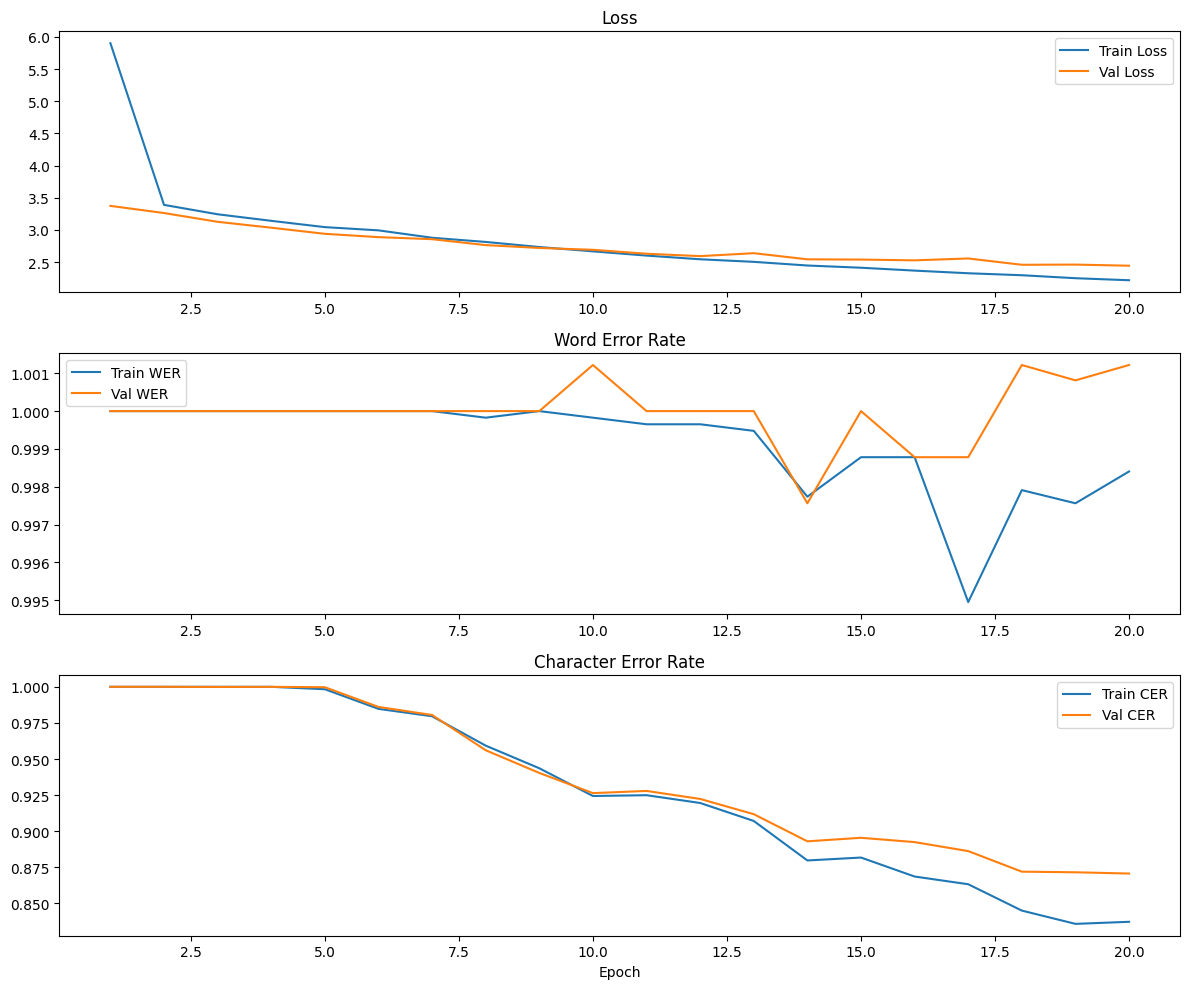

In [78]:
# Plot metrics including CER curves
epochs=list(range(1,len(hist['train_loss'])+1))
plt.figure(figsize=(12,10))
# Loss, WER, CER
plt.subplot(3,1,1)
plt.plot(epochs, hist['train_loss'], label='Train Loss')
plt.plot(epochs, hist['val_loss'],   label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(epochs, hist['train_wer'], label='Train WER')
plt.plot(epochs, hist['val_wer'],   label='Val WER')
plt.title('Word Error Rate')
plt.legend()

plt.subplot(3,1,3)
plt.plot(epochs, hist['train_cer'], label='Train CER')
plt.plot(epochs, hist['val_cer'],   label='Val CER')
plt.title('Character Error Rate')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()